In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

In [38]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


####Loading the data

In [39]:
path = "/content/drive/MyDrive/Datasets/creditcard.csv"

try:
  df = pd.read_csv(path)
  print("Data set is loaded")
  print("Shape ", df.shape)
except FileNotFoundError:
  print("File not found")

Data set is loaded
Shape  (284807, 31)


In [40]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


####EDA and Sanity Check

In [41]:
missing_vals = df.isnull().sum()
missing_vals

,0
Time,0
V1,0
V2,0
V3,0
V4,0
V5,0
V6,0
V7,0
V8,0
V9,0


In [42]:
df[df.isnull().any(axis=1)]

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class


In [43]:
df = df.dropna()
df.isna().sum().sum()

np.int64(0)

In [44]:
fraud_count = df['Class'].value_counts()
print("Non fraud - class 0 = ", fraud_count[0])
print("fraud - class 1 = ", fraud_count[1])

Non fraud - class 0 =  284315
fraud - class 1 =  492


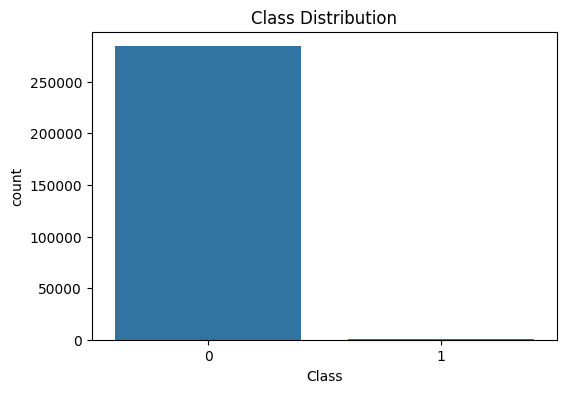

In [45]:
plt.figure(figsize=(6, 4))
sns.countplot(x='Class', data=df)
plt.title("Class Distribution")
plt.show()

In [46]:
df['Amount'].describe()

,Amount
count,284807.000000
mean,88.349619
std,250.120109
min,0.000000
25%,5.600000
50%,22.000000
75%,77.165000
max,25691.160000


####Data preprocesing and train test split

In [47]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [48]:
df["Amount_Scaled"] = StandardScaler().fit_transform(df["Amount"].values.reshape(-1, 1))

In [49]:
df = df.drop(["Time", "Amount"], axis=1)

In [50]:
X = df.drop("Class", axis=1)
y = df["Class"]

print(X.shape)
print(y.shape)

(284807, 29)
(284807,)


In [51]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("X_train: ", X_train.shape)
print("X_test: ", X_test.shape)
print("y_train: ", y_train.shape)
print("y_test: ", y_test.shape)

X_train:  (227845, 29)
X_test:  (56962, 29)
y_train:  (227845,)
y_test:  (56962,)


####Model Training

In [52]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(
    n_estimators=100,
    max_depth=12,
    random_state=42,
    class_weight="balanced",
    n_jobs=-1,
    verbose=1
)

model.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  3.0min finished


RandomForestClassifier(class_weight='balanced', max_depth=12, n_jobs=-1,
                       random_state=42, verbose=1)

####Model Evaluation

In [53]:
from sklearn.metrics import (confusion_matrix, classification_report, roc_auc_score, precision_recall_curve, auc)

In [54]:
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.2s finished


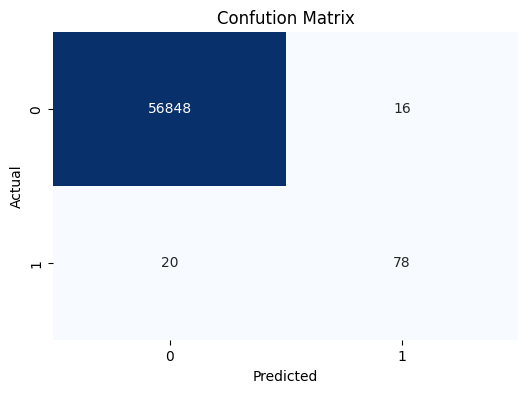

In [55]:
plt.figure(figsize=(6, 4))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confution Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [56]:
print("Classification Report: \n")
print(classification_report(y_test, y_pred))

Classification Report: 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.83      0.80      0.81        98

    accuracy                           1.00     56962
   macro avg       0.91      0.90      0.91     56962
weighted avg       1.00      1.00      1.00     56962



####Appling smote for make synthetic data

In [57]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)

print("Original fraud count: ", y_train.sum())

X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print("New fraud count: ", y_train_resampled.sum())

Original fraud count:  394
New fraud count:  227451


####Retrain the new model

In [58]:
model_smote = RandomForestClassifier(
    n_estimators=100,
    max_depth=12,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

model_smote.fit(X_train_resampled, y_train_resampled)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  7.4min finished


RandomForestClassifier(max_depth=12, n_jobs=-1, random_state=42, verbose=1)

In [59]:
y_prob_smote = model_smote.predict_proba(X_test)[:, 1]
y_pred_smote = model_smote.predict(X_test)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.4s finished


In [60]:
print("Classification Report after smoting: \n")
print(classification_report(y_test, y_pred_smote))

Classification Report after smoting: 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.54      0.87      0.67        98

    accuracy                           1.00     56962
   macro avg       0.77      0.93      0.83     56962
weighted avg       1.00      1.00      1.00     56962



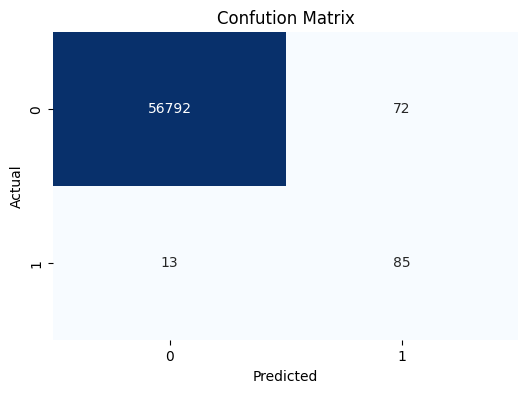

In [61]:
plt.figure(figsize=(6, 4))
cm = confusion_matrix(y_test, y_pred_smote)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confution Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [62]:
def evaluate_threshold(y_test, y_prob, threshold):
  y_pred_custom = (y_prob >= threshold).astype(int)

  print("Threshold: ", threshold)
  tn, fp, fn, tp = confusion_matrix(y_test, y_pred_custom).ravel()
  print("TP (Identified fraud): ", tn)
  print("FN (Missed fraud): ", fn)
  print("FP (False alarm): ", fp)

  precision = tp / (tp + fp)
  recall = tp / (tp + fn)
  f1_score = 2 * (precision * recall) / (precision + recall)

  print("Precision: ", precision)
  print("Recall: ", recall)
  print("F1 score: ", f1_score)
  print("\n")


In [63]:
evaluate_threshold(y_test, y_prob_smote, threshold=0.5) # Default
evaluate_threshold(y_test, y_prob_smote, threshold=0.2) # Aggressive
evaluate_threshold(y_test, y_prob_smote, threshold=0.1) # Very Aggressive

Threshold:  0.5
TP (Identified fraud):  56792
FN (Missed fraud):  13
FP (False alarm):  72
Precision:  0.5414012738853503
Recall:  0.8673469387755102
F1 score:  0.6666666666666665


Threshold:  0.2
TP (Identified fraud):  56095
FN (Missed fraud):  9
FP (False alarm):  769
Precision:  0.10372960372960373
Recall:  0.9081632653061225
F1 score:  0.18619246861924685


Threshold:  0.1
TP (Identified fraud):  54123
FN (Missed fraud):  7
FP (False alarm):  2741
Precision:  0.03213276836158192
Recall:  0.9285714285714286
F1 score:  0.0621160409556314




####Saving the model articats

In [64]:
from google.colab import drive
drive.mount('/content/drive')

file_name = "rf_fraud_model.pkl"

joblib.dump(model_smote, f"/content/drive/MyDrive/{file_name}")

feature_names = list(X.columns)
joblib.dump(feature_names, f"/content/drive/MyDrive/model_features.pkl'")
print("Model saved")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Model saved


In [66]:
df_temp = pd.read_csv("/content/drive/MyDrive/Datasets/creditcard.csv")

scaler = StandardScaler()
scaler.fit(df_temp[["Amount"]])

joblib.dump(scaler, "/content/drive/MyDrive/scaler.pkl")
print("Scaler saved")

Scaler saved
